Cyna Shirazinejad, 7/7/21

# Notebook 11b: merge AP2 with ARPC3, 'zero' padding

outline:
* find ARPC3+/- events
* measure the effect of CCP motility with ARPC3 recruitment

##### import all necessary Python modules

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pickle
from IPython.display import Image
from tqdm import tqdm
import warnings
from scipy import signal

%matplotlib inline
unique_user_path_notebook = str(np.load('unique_user_path_notebook.npy'))
unique_user_saved_outputs = str(np.load('unique_user_saved_outputs.npy'))
unique_user_saved_tracks = str(np.load('unique_user_path_tracks.npy'))
sys.path.append(unique_user_path_notebook+'/cmeAnalysisPostProcessingPythonScripts') # add custom Python scripts to the local path
import merge_tools
import generate_index_dictionary
import return_track_attributes
index_dictionary = generate_index_dictionary.return_index_dictionary()

# load dataframe from notebook 3 containing normal-pdf scaled features: PC's and GMM predicted clusters, and dataframe with cmeAnalysis labels

In [2]:
df_pcs_normal_scaled_with_gmm_cluster = pd.read_csv(unique_user_saved_outputs+'/dataframes/df_new_incorporated_data_pcs_gmm_clusters.zip')
df_merged_features = pd.read_csv(unique_user_saved_outputs+'/dataframes/df_new_incorporated_data_merged_features.zip')
index_dnm2positive = np.load(unique_user_saved_outputs+'/dataframes/cluster_dnm2_positive.npy')
number_of_track_splits = np.load(unique_user_saved_outputs+'/dataframes/number_of_track_splits.npy')
number_of_clusters = np.load(unique_user_saved_outputs+"/dataframes/number_of_clusters.npy")
ccp_predictions = np.load(unique_user_saved_outputs+'/dataframes/merged_ccp_predictions.npy')

In [3]:
best_fit_peak_params = np.load(unique_user_saved_outputs+'/dataframes/parameters_best_fit_peak_finding.npy')
sos = signal.butter(4, 0.2, 'lp', fs=1, output='sos')

In [4]:
df_merged_features

,lifetime,max_int_ap2,max_int_dnm2,dist_traveled_ap2,dist_traveled_dnm2,max_dist_between_ap2_dnm2,md_ap2,md_dnm2,time_to_peak_ap2,time_to_peak_dnm2,...,kurtosis_dnm2,number_significant_dnm2,max_consecutive_significant_dnm2,fraction_significant_dnm2,fraction_peak_ap2,fraction_peak_dnm2,experiment_number,number_of_channels,date,cmeAnalysis_dynamin2_prediction
0,216.0,1796.284550,740.516756,7.203812,7.203812,2.630656,0.566262,0.725913,159.0,186.0,...,0.889904,167.0,43.0,0.738938,0.703540,0.823009,0.0,2.0,200804.0,1.0
1,201.0,2215.532695,1505.433273,17.220726,14.507135,3.797526,0.424574,0.912671,111.0,107.0,...,8.009901,115.0,89.0,0.545024,0.526066,0.507109,0.0,2.0,200804.0,1.0
2,201.0,864.976087,421.405691,17.621866,17.130473,3.472332,0.566588,0.776404,42.0,44.0,...,0.807456,167.0,70.0,0.791469,0.199052,0.208531,0.0,2.0,200804.0,1.0
3,192.0,509.795166,356.302521,10.804211,13.292842,5.888569,0.428736,1.058177,44.0,190.0,...,4.081995,112.0,57.0,0.554455,0.217822,0.940594,0.0,2.0,200804.0,1.0
4,188.0,1636.422386,883.606436,11.255090,7.793074,5.531006,0.415792,0.753372,174.0,169.0,...,2.885473,169.0,80.0,0.853535,0.878788,0.853535,0.0,2.0,200804.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154359,2.0,71.707995,35.951988,5.059682,5.014421,2.181787,0.766658,1.257316,5.0,4.0,...,0.652187,0.0,0.0,0.000000,0.416667,0.333333,20.0,3.0,200722.0,0.0
154360,2.0,25.338391,38.053364,2.261592,2.067468,4.632292,1.427061,1.486410,6.0,2.0,...,-0.519547,7.0,3.0,0.583333,0.500000,0.166667,20.0,3.0,200722.0,1.0
154361,2.0,207.539790,166.846303,2.391855,2.634261,4.270496,1.536834,1.356576,5.0,0.0,...,-0.467286,5.0,3.0,0.416667,0.416667,0.000000,20.0,3.0,200722.0,1.0
154362,2.0,16.610995,36.530651,3.546351,2.761683,3.700703,1.630578,1.907946,5.0,9.0,...,-1.330293,2.0,1.0,0.166667,0.416667,0.750000,20.0,3.0,200722.0,0.0


# load all valid arpc3 tracks

In [5]:
valid_tracks_arpc3 = [np.load(unique_user_saved_outputs+'/dataframes/valid_arpc3_tracks_0.npy', allow_pickle=True)]

for i in range(1, 13):
    valid_tracks_arpc3 += [np.load(unique_user_saved_outputs+'/dataframes/valid_arpc3_tracks_'+str(i)+'.npy', allow_pickle=True)]

In [6]:
merged_valid_tracks_arpc3 = merge_tools.merge_experiments(valid_tracks_arpc3,[list(range(len(track_set))) for track_set in valid_tracks_arpc3])

# load all valid tracks

In [7]:
merged_all_valid_tracks = np.load(unique_user_saved_outputs+'/dataframes/all_experiments_merged_all_valid_tracks_0.npy', allow_pickle=True)

for i in range(1, number_of_track_splits):

    merged_all_valid_tracks = np.concatenate((merged_all_valid_tracks,
                                              np.load(unique_user_saved_outputs+'/dataframes/all_experiments_merged_all_valid_tracks_'+str(i)+'.npy', allow_pickle=True)))

In [8]:
merged_all_valid_tracks.shape

(154364,)

# sort DNM2+ events

In [9]:
num_gmm_clusters = number_of_clusters # optimal number of clusters of PCA data


gmm_classes = []

for i in range(num_gmm_clusters):

    gmm_classes.append(df_pcs_normal_scaled_with_gmm_cluster[df_pcs_normal_scaled_with_gmm_cluster['gmm_predictions']==i].index.values)    

In [10]:
len(gmm_classes[index_dnm2positive])

13797

In [11]:
tracks_authentic_ccps_gmm = merged_all_valid_tracks[gmm_classes[index_dnm2positive]] #dnm2 positive events, mixed CCPS and hot-spots

In [12]:
len(tracks_authentic_ccps_gmm)

13797

# isolate hot-spot and individual CCP mixed authentic CCP class from gmm

In [13]:
experiment_number_track_candidates = df_merged_features['experiment_number'][gmm_classes[index_dnm2positive]] # experiment numbers (1-16)

In [14]:
len(experiment_number_track_candidates)

13797

# separate single-CCP events by experiment

In [15]:
merged_all_valid_tracks_per_experiment = [] # each entry is a list for each experiment of tracks corresponding to predicted ccps 
hotspot_events_per_experiment = [] # each entry is a list for each experiment of tracks corresponding to predicted hot-spots 
ccp_events_per_experiment = []

for experiment_number in range(8, 21): # only look at 3-color movies
    
    current_exp_ind = np.where(experiment_number_track_candidates==experiment_number)[0] # all events in current experiment
    hotspot_pred_exp = ccp_predictions[current_exp_ind] # hot-spot predictions for current experiment
    tracks_exp = tracks_authentic_ccps_gmm[current_exp_ind] # all tracks in current experiment
    
    non_hotspot_ind = np.where(hotspot_pred_exp==1)[0] # single ccp event indices
    tracks_single_ccp_exp = tracks_exp[non_hotspot_ind] # single ccp tracks
    ccp_events_per_experiment.append(tracks_single_ccp_exp)

<!-- # measure ap2 initiation to dnm2 peak lifetime, comparing 2 cell lines -->

# merge all CCPs

In [16]:
merged_ccps = merge_tools.merge_experiments(ccp_events_per_experiment, [list(range(len(track_set))) for track_set in ccp_events_per_experiment])

In [17]:
len(merged_ccps)

3302

# reload (or load) trees 

In [18]:
arpc3_trees = []

for i in range(8,21):
    
    with open(unique_user_saved_outputs+'/dataframes/arpc3_kdtree_'+str(i), 'rb') as f:
        tree = pickle.load(f)
        
    index_matrix = np.load(unique_user_saved_outputs+"/dataframes/arpc3_tree_index_matrix_"+str(i)+'.npy', allow_pickle=True)

    arpc3_trees.append([tree, index_matrix])

In [19]:
distance_query = 2 # pixel search radius for associating ap2 and arpc3 from separate tracking

# arpc3 positive events, padded in non-overlapping frames
ch0_vectors_arpc3_positive = [] # amplitudes #
ch1_vectors_arpc3_positive = [] #
ch2_vectors_arpc3_positive = [] #
channel_0_1_separations_arpc3_positive = [] # distance in microns between ap2 and dnm2
channel_0_2_separations_arpc3_positive = [] # distance in microns between ap2 and arpc3
channel_1_2_separations_arpc3_positive = []
final_separations_ap2arpc3_arpc3_positive = [] # ap2 and arpc3 final separation in last overlapping frame of ap2 and arpc3
initial_separations_ap2arpc3_arpc3_positive = [] # ap2 and arpc3 initial separation in first overlapping frame of ap2 and arpc3
ap2_arpc3_separation_at_dnm2_peak_arpc3_positive = [] # ap2 and arpc3 separation at peak of dnm2 signal
ap2_arpc3_separation_at_arpc3_peak_arpc3_positive = []
ap2_arpc3_separation_at_ap2_peak_arpc3_positive = []
ap2_lifetime_arpc3_positive = [] # ap2 lifetime
arpc3_lifetime_arpc3_positive = []
max_separation_ap2_arpc3_arpc3_positive = [] # maximum separation between ap2 and arpc3
max_separation_ap2_dnm2_arpc3_positive = []
max_separation_dnm2_arpc3_arpc3_positive = []
num_frames_associated_arpc3_positive = [] # number of frames shared between ap2 and arpc3 in movie that are below the query radius in KDTree search
time_ap2_appearance_to_dnm2_peak_arpc3_positive = []
maximum_ap2_intensity_arpc3_positive = []
maximum_dnm2_intensity_arpc3_positive = []
maximum_arpc3_intensity_arpc3_positive = []
pval_arpc3_ccps_arpc3_positive = []
time_arpc3_appearance_to_dnm2_peak_arpc3_positive = []
fraction_arpc3_positive = []
ccps_arpc3_positive = []
average_ap2_movement_before_dnm2_peak_arpc3_positive = []
average_ap2_movement_after_dnm2_peak_arpc3_positive = []

ap2_arpc3_separation_average_arpc3_positive = []
experiment_number_arpc3_positive = []
dnm2_arpc3_peak_time_difference_arpc3_positive = []


# arpc3 negative events
ch0_vectors_arpc3_negative = []
ch1_vectors_arpc3_negative = []
channel_0_1_separations_arpc3_negative = []
ccps_arpc3_negative = []
time_ap2_appearance_to_dnm2_peak_arpc3_negative = []
ap2_lifetime_arpc3_negative = []
experiment_number_arpc3_negative = []
average_ap2_movement_before_dnm2_peak_arpc3_negative = []
average_ap2_movement_after_dnm2_peak_arpc3_negative = []


num_frames_associated = []


significant_arpc3_at_dnm2_peak_arpc3_positive = []

num_no_neighbors = 0

for experiment_number in range(8,21):  # iterate over all experiments

    
    num_with_mode = 0 # count number of events with and without arpc3
    num_without_mode = 0    
    num_no_neighbors=0
    print('current experiment number: ' + str(experiment_number))
    ap2dmn2_tracks_in_experiment = ccp_events_per_experiment[experiment_number-8] # filtered tracks
    print('number of ap2 tracks: ' + str(len(ap2dmn2_tracks_in_experiment)))
    arpc3_experiment=valid_tracks_arpc3[experiment_number-8] # cat 1 and 2 arpc3 events in experiment
    print('number of arpc3 tracks: ' + str(len(arpc3_experiment)))

    
    # select a tree for each frame containing all events in each frame
    kd_tree_arpc3_experiment, vals_tree = arpc3_trees[experiment_number-8]
    
    print('iterating through tracks in experiment')
    
    for track_num in range(len(ap2dmn2_tracks_in_experiment)): # iterate through all ap2 tracks in experiment

        
        frames_in_track_first_channel = list(return_track_attributes.return_frames_in_track_no_buffer(ap2dmn2_tracks_in_experiment, track_num)-1) # frames of ap2 and dnm2
        ch0_x = return_track_attributes.return_puncta_x_position_no_buffer_one_channel(ap2dmn2_tracks_in_experiment, track_num, 0) # positions of ap2 and dnm2
        ch0_y = return_track_attributes.return_puncta_y_position_no_buffer_one_channel(ap2dmn2_tracks_in_experiment, track_num, 0)
        ch1_x = return_track_attributes.return_puncta_x_position_no_buffer_one_channel(ap2dmn2_tracks_in_experiment, track_num, 1)
        ch1_y = return_track_attributes.return_puncta_y_position_no_buffer_one_channel(ap2dmn2_tracks_in_experiment, track_num, 1)
        ap2_int = return_track_attributes.return_track_amplitude_no_buffer_channel(ap2dmn2_tracks_in_experiment, track_num, 0) # ap2 and dnm2 intensities
        dnm2_int = return_track_attributes.return_track_amplitude_no_buffer_channel(ap2dmn2_tracks_in_experiment, track_num, 1)
        
        filtered_dnm2_signal = list(list(signal.sosfilt(sos, dnm2_int)) + [0, 0, 0, 0, 0])
    
        dnm2_peak = signal.find_peaks(filtered_dnm2_signal, 
                                      distance=best_fit_peak_params[0], 
                                      height=best_fit_peak_params[1],
                                      width=best_fit_peak_params[2])[0][0]
        
        frame_dnm2_peak = frames_in_track_first_channel[dnm2_peak] # the movie frame (indexed starting from 0) that dnm2 peaks     
        candidate_arpc3_neighbors = [] # indices of arpc3 events that take place near ap2
        no_neighbors=True # no neighbors found yet
        
        # search for candidate arpc3 neighbors in each ap2 track's frame
        for frame in frames_in_track_first_channel:
            
            frame_ch0 = frames_in_track_first_channel.index(frame)
            # frame's tree
            current_tree = kd_tree_arpc3_experiment[frame]
            
            # ap2 fitted position at current frame
            current_ap2_position = np.array([ch0_x[frame_ch0], ch0_y[frame_ch0]]).reshape(1, -1)
            
            # indices of arpc3 events within the query radius
            ind = current_tree.query_radius(current_ap2_position,
                                            r=distance_query)

            if len(ind[0])>0:
                no_neighbors = False # if there is a neighbor
                
            # check if each arpc3 neighbor originated before or after the ap2 event
            for candidate in ind[0]:

                candidate_index = int(vals_tree[frame][candidate][0]) # get the index of the arpc3 event
                
                frames_in_track_candidate_neighbor = list(return_track_attributes.return_frames_in_track_no_buffer(arpc3_experiment, candidate_index)-1)
                
                # consider the arpc3 event if it originated after the ap2 event and before the dnm2 peak
                if frames_in_track_candidate_neighbor[0]>frames_in_track_first_channel[0] and frames_in_track_candidate_neighbor[0]<frame_dnm2_peak:

                    candidate_arpc3_neighbors.append(candidate_index)
        
            
        if no_neighbors==True: # if there are absolutely no neighbors present, the CCP is arpc3 negative
            
            num_no_neighbors+=1
            
        # get mode(s) of candidates
        mode=stats.mode(candidate_arpc3_neighbors)
        
        # if there is a unique candidate:
        if mode[0].size == 1:

            num_frames_associated.append(mode[1][0])
            
            num_with_mode+=1 # count this track as arpc3 positive

            pval_arpc3_detection = []
            
        
            associated_track_second_channel = mode[0][0] # index of arpc3 track associated with current ap2 track
            
            frames_in_track_second_channel = list(return_track_attributes.return_frames_in_track_no_buffer(arpc3_experiment, associated_track_second_channel)-1) # frames of arpc3 track
            
            frames_intersection = list(set(frames_in_track_first_channel) & set(frames_in_track_second_channel)) # find all frames ap2 and arpc3 overlap during movie
            frames_intersection.sort() # sort the frames in ascending order

            # amplitudes of all channels
            ch0_amplitudes = ap2_int # ap2, dnm2, arpc3 intensities
            ch1_amplitudes = dnm2_int
            ch2_amplitudes = return_track_attributes.return_track_amplitude_no_buffer_channel(arpc3_experiment, associated_track_second_channel, 0)

            # position of arpc3
            ch2_x = return_track_attributes.return_puncta_x_position_no_buffer_one_channel(arpc3_experiment, associated_track_second_channel, 0)
            ch2_y = return_track_attributes.return_puncta_y_position_no_buffer_one_channel(arpc3_experiment, associated_track_second_channel, 0)

            # correct intensities and positions for missing frames where ap2 and arpc3 are non-overlapping
            new_ch0_vector = []
            new_ch1_vector = []
            new_ch2_vector = []
            new_ch0_x = []
            new_ch0_y = []
            new_ch1_x = []
            new_ch1_y = []
            new_ch2_x = []
            new_ch2_y = []
            
            # first/last frame either ap2 or arpc3 shows up
            min_frame = np.nanmin([np.nanmin(frames_in_track_first_channel),np.nanmin(frames_in_track_second_channel)]) #nan to account for gaps
            max_frame = np.nanmax([np.nanmax(frames_in_track_first_channel),np.nanmax(frames_in_track_second_channel)])

            # all frames shared between ap2 and arpc3
            frames_all = [i for i in range(int(min_frame),int(max_frame)+1)]

            channel_0_2_separation_track = [] # ap2 and arpc3 separation
            channel_0_2_angle_track = [] # ap2 and arpc3 angle 
            channel_0_1_separation_track = [] # ap2 and dnm2 separation
            channel_1_2_separation_track = []

            for frame in frames_all: # iterate over all frames

                # if frames of ap2 and arpc3 are non-overlapping, do not measure their separation
                if (frame in frames_in_track_first_channel and frame not in frames_in_track_second_channel) or (frame in frames_in_track_second_channel and frame not in frames_in_track_first_channel):
                    channel_0_2_separation_track.append(0)
                    channel_0_2_angle_track.append(0)
                    channel_1_2_separation_track.append(0)
                # if only ap2 is present
                if frame in frames_in_track_first_channel and frame not in frames_in_track_second_channel:
                    
                    channel_0_index = frames_in_track_first_channel.index(frame) # get relative index of ap2 in this frame 

                    new_ch0_vector.append(ch0_amplitudes[channel_0_index]) # add ap2 and dnm2 amplitudes
                    new_ch1_vector.append(ch1_amplitudes[channel_0_index]) 
                    new_ch0_x.append(ch0_x[channel_0_index]) # ap2 and dnm2 positions
                    new_ch0_y.append(ch0_y[channel_0_index])
                    new_ch1_x.append(ch1_x[channel_0_index])
                    new_ch1_y.append(ch1_y[channel_0_index])

                    new_ch2_vector.append(0) # no arpc3
                    new_ch2_x.append(0) # arpc3 position off grid
                    new_ch2_y.append(0)
                    pval_arpc3_detection.append(np.NaN)
                    
                    channel_0_1_separation_track.append(np.sqrt((0.108*(ch0_x[channel_0_index]-ch1_x[channel_0_index]))**2 + (0.108*(ch0_y[channel_0_index]-ch1_y[channel_0_index]))**2)) # ap2-dnm2 separation

                # if only arpc3 is present
                elif frame in frames_in_track_second_channel and frame not in frames_in_track_first_channel: 

                    channel_2_index = frames_in_track_second_channel.index(frame) # get relative index of arpc3 in this frame 

                    new_ch2_vector.append(ch2_amplitudes[channel_2_index]) # add arpc3 amplitudes and positions
                    new_ch2_x.append(ch2_x[channel_2_index]) 
                    new_ch2_y.append(ch2_y[channel_2_index])
                    
                    new_ch0_vector.append(0) # no ap2 or dnm2
                    new_ch1_vector.append(0)    
                    new_ch0_x.append(0) # ap2 and dnm2 position off grid
                    new_ch0_y.append(0)
                    new_ch1_x.append(0)
                    new_ch1_y.append(0)
           
                    channel_0_1_separation_track.append(0) # no separation between ap2 and dnm2 
                    
                    pval_arpc3_detection.append(return_track_attributes.return_pvals_detection_no_buffer(arpc3_experiment, associated_track_second_channel, 0)[channel_2_index])
                
                # if both ap2 and arpc3 in frame
                elif frame in frames_in_track_first_channel and frame in frames_in_track_second_channel:  

                    channel_0_index = frames_in_track_first_channel.index(frame) # get relative indices
                    channel_2_index = frames_in_track_second_channel.index(frame)

                    new_ch0_vector.append(ch0_amplitudes[channel_0_index]) # add amplitudes and positionsfor all channels
                    new_ch1_vector.append(ch1_amplitudes[channel_0_index])
                    new_ch2_vector.append(ch2_amplitudes[channel_2_index])
                    new_ch0_x.append(ch0_x[channel_0_index]) # ap2 and dnm2 positions
                    new_ch0_y.append(ch0_y[channel_0_index])
                    new_ch1_x.append(ch1_x[channel_0_index])
                    new_ch1_y.append(ch1_y[channel_0_index])
                    new_ch2_x.append(ch2_x[channel_2_index]) 
                    new_ch2_y.append(ch2_y[channel_2_index])

                    channel_0_1_separation_track.append(np.sqrt((0.108*(ch0_x[channel_0_index]-ch1_x[channel_0_index]))**2 + (0.108*(ch0_y[channel_0_index]-ch1_y[channel_0_index]))**2)) # ap2-dnm2 separation
                    
                    # ap2 and arpc3 separation
                    channel_0_2_separation_track.append(np.sqrt((0.108*(ch0_x[channel_0_index]-ch2_x[channel_2_index]))**2 + (0.108*(ch0_y[channel_0_index]-ch2_y[channel_2_index]))**2))
#                     channel_0_2_angle_track.append(angle_between((0,0),((ch0_x[channel_0_index]-ch2_x[channel_2_index]),(ch0_y[channel_0_index]-ch2_y[channel_2_index]))))              
                    channel_1_2_separation_track.append(np.sqrt((0.108*(ch1_x[channel_0_index]-ch2_x[channel_2_index]))**2 + (0.108*(ch1_y[channel_0_index]-ch2_y[channel_2_index]))**2))

                    pval_arpc3_detection.append(return_track_attributes.return_pvals_detection_no_buffer(arpc3_experiment,associated_track_second_channel,0)[channel_2_index])
 
            filtered_dnm2_signal = list(list(signal.sosfilt(sos, dnm2_int)) + [0, 0, 0, 0, 0])
    
            dnm2_peak = signal.find_peaks(filtered_dnm2_signal, 
                                          distance=best_fit_peak_params[0], 
                                          height=best_fit_peak_params[1],
                                          width=best_fit_peak_params[2])[0][0]
        
            if pval_arpc3_detection[dnm2_peak]<0.01 and pval_arpc3_detection[dnm2_peak]!=np.NaN:
            
                significant_arpc3_at_dnm2_peak_arpc3_positive.append(1)
            
            else:
                
                significant_arpc3_at_dnm2_peak_arpc3_positive.append(0)
    
            ccps_arpc3_positive.append(ap2dmn2_tracks_in_experiment[track_num])
            ap2_lifetime_arpc3_positive.append(len(frames_in_track_first_channel))
            arpc3_lifetime_arpc3_positive.append(len(frames_in_track_second_channel))
            # measure ap2 and arpc3 separation at dnm2 peak

            ap2_arpc3_separation_at_dnm2_peak_arpc3_positive.append(channel_0_2_separation_track[dnm2_peak])
            ap2_arpc3_separation_at_arpc3_peak_arpc3_positive.append(channel_0_2_separation_track[np.nanargmax(new_ch2_vector)])
            ap2_arpc3_separation_at_ap2_peak_arpc3_positive.append(channel_0_2_separation_track[np.nanargmax(new_ch0_vector)])
            ap2_arpc3_separation_average_arpc3_positive.append(np.nanmean(channel_0_2_separation_track))
            # store measurements
            ch0_vectors_arpc3_positive.append(new_ch0_vector)
            ch1_vectors_arpc3_positive.append(new_ch1_vector)
            ch2_vectors_arpc3_positive.append(new_ch2_vector)
#             print(new_ch2_vector)
            channel_0_2_separations_arpc3_positive.append(channel_0_2_separation_track)
            channel_0_1_separations_arpc3_positive.append(channel_0_1_separation_track)  
            channel_1_2_separations_arpc3_positive.append(channel_1_2_separation_track)  
            channel_0_2_separation_track = np.array(channel_0_2_separation_track)
            channel_0_1_separation_track = np.array(channel_0_1_separation_track)
            channel_1_2_separation_track = np.array(channel_1_2_separation_track)
            final_separations_ap2arpc3_arpc3_positive.append(channel_0_2_separation_track[~np.isnan(channel_0_2_separation_track)][-1])      
            initial_separations_ap2arpc3_arpc3_positive.append(channel_0_2_separation_track[~np.isnan(channel_0_2_separation_track)][0])   
            max_separation_ap2_arpc3_arpc3_positive.append(np.nanmax(channel_0_2_separation_track))
            max_separation_ap2_dnm2_arpc3_positive.append(np.nanmax(channel_0_1_separation_track))
            max_separation_dnm2_arpc3_arpc3_positive.append(np.nanmax(channel_1_2_separation_track))
            num_frames_associated_arpc3_positive.append(mode[1][0])
            pval_arpc3_ccps_arpc3_positive.append(pval_arpc3_detection)
            maximum_ap2_intensity_arpc3_positive.append(np.nanmax(new_ch0_vector))
            maximum_dnm2_intensity_arpc3_positive.append(np.nanmax(new_ch1_vector))
            maximum_arpc3_intensity_arpc3_positive.append(np.nanmax(new_ch2_vector))      
            time_ap2_appearance_to_dnm2_peak_arpc3_positive.append(dnm2_peak)
            time_arpc3_appearance_to_dnm2_peak_arpc3_positive.append(int(frames_in_track_first_channel[dnm2_peak]) - int(frames_in_track_second_channel[0]))
            experiment_number_arpc3_positive.append(experiment_number)
            
            dnm2_arpc3_peak_time_difference_arpc3_positive.append(np.nanargmax(ch1_amplitudes)-np.nanargmax(ch2_amplitudes))
            
            # concatenate all track positions and amplitudes
            track_x_positions = [new_ch0_x, new_ch1_x, new_ch2_x]
            track_y_positions = [new_ch0_y, new_ch1_y, new_ch2_y]
            channel_intensity_vectors = [new_ch0_vector, new_ch1_vector, new_ch2_vector]   
             
            ap2_x_positions = new_ch0_x
            ap2_y_positions = new_ch0_y     
            
            num_before=5
            ap2movement = []
            for dnm2_index in range(dnm2_peak-num_before,dnm2_peak):

                try: 
                    
                    if ap2_x_positions[dnm2_index] != 0 and ap2_x_positions[dnm2_index+1] != 0:
                        
                        ap2temp = np.sqrt((0.108*(ap2_x_positions[dnm2_index+1]-ap2_x_positions[dnm2_index]))**2 + (0.108*(ap2_y_positions[dnm2_index+1]-ap2_y_positions[dnm2_index]))**2)

                        ap2movement.append(ap2temp)
                        
                    else:
                        
                        ap2movement.append(np.NaN)

                except Exception:

                    ap2movement.append(np.NaN)

            average_ap2_movement_before_dnm2_peak_arpc3_positive.append(np.nanmean(ap2movement))            

            num_after=5
            ap2movement = []
            for dnm2_index in range(dnm2_peak,dnm2_peak+num_after):

                try: 
                    
                    if ap2_x_positions[dnm2_index] != 0 and ap2_x_positions[dnm2_index+1] != 0:
                        
                        ap2temp = np.sqrt((0.108*(ap2_x_positions[dnm2_index+1]-ap2_x_positions[dnm2_index]))**2 + (0.108*(ap2_y_positions[dnm2_index+1]-ap2_y_positions[dnm2_index]))**2)

                        ap2movement.append(ap2temp)
                        
                    else:
                        
                        ap2movement.append(np.NaN)

                except Exception:

                    ap2movement.append(np.NaN)

            average_ap2_movement_after_dnm2_peak_arpc3_positive.append(np.nanmean(ap2movement)) 
            
        elif no_neighbors==True: # if there is no mode then the event is arpc3 negative

            num_without_mode += 1 
            experiment_number_arpc3_negative.append(experiment_number)
            ccps_arpc3_negative.append(ap2dmn2_tracks_in_experiment[track_num])
            ap2_lifetime_arpc3_negative.append(len(ap2_int))

            ch0_vectors_arpc3_negative.append(ap2_int)
            ch1_vectors_arpc3_negative.append(dnm2_int)

            filtered_dnm2_signal = list(list(signal.sosfilt(sos, dnm2_int)) + [0, 0, 0, 0, 0])
    
            dnm2_peak = signal.find_peaks(filtered_dnm2_signal, 
                                          distance=best_fit_peak_params[0], 
                                          height=best_fit_peak_params[1],
                                          width=best_fit_peak_params[2])[0][0]
            
            time_ap2_appearance_to_dnm2_peak_arpc3_negative.append(dnm2_peak)
            
                        
            channel_0_1_separation_track = []
            
            for frame in range(len(ch0_x)):
                
                channel_0_1_separation_track.append(np.sqrt((0.108*(ch0_x[frame]-ch1_x[frame]))**2 + (0.108*(ch0_y[frame]-ch1_y[frame]))**2)) # ap2-dnm2 separation

            channel_0_1_separations_arpc3_negative.append(channel_0_1_separation_track)
         
            ap2_x_positions = ch0_x
            ap2_y_positions = ch0_y     
        
            num_before=5
            ap2movement = []
            for dnm2_index in range(dnm2_peak-num_before,dnm2_peak):

                try: 

                    ap2temp = np.sqrt((0.108*(ap2_x_positions[dnm2_index+1]-ap2_x_positions[dnm2_index]))**2 + (0.108*(ap2_y_positions[dnm2_index+1]-ap2_y_positions[dnm2_index]))**2)

                    ap2movement.append(ap2temp)

                except Exception:

                    ap2movement.append(np.NaN)

            average_ap2_movement_before_dnm2_peak_arpc3_negative.append(np.nanmean(ap2movement))            

            num_after=5
            ap2movement = []
            for dnm2_index in range(dnm2_peak,dnm2_peak+num_after):

                try: 

                    ap2temp = np.sqrt((0.108*(ap2_x_positions[dnm2_index+1]-ap2_x_positions[dnm2_index]))**2 + (0.108*(ap2_y_positions[dnm2_index+1]-ap2_y_positions[dnm2_index]))**2)

                    ap2movement.append(ap2temp)

                except Exception:

                    ap2movement.append(np.NaN)

            average_ap2_movement_after_dnm2_peak_arpc3_negative.append(np.nanmean(ap2movement))             
          
    print('fraction of events with arpc3', str(num_with_mode/(num_with_mode+num_no_neighbors)))
    fraction_arpc3_positive.append(num_with_mode/(num_with_mode+num_no_neighbors))   

current experiment number: 8
number of ap2 tracks: 306
number of arpc3 tracks: 17512
iterating through tracks in experiment


/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:354: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:417: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:354: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:354: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:354: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:354: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.p

fraction of events with arpc3 0.6879699248120301
current experiment number: 9
number of ap2 tracks: 310
number of arpc3 tracks: 16177
iterating through tracks in experiment


/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:417: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:354: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:417: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:354: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:354: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:417: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.p

fraction of events with arpc3 0.6336996336996337
current experiment number: 10
number of ap2 tracks: 290
number of arpc3 tracks: 15491
iterating through tracks in experiment


/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:354: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:354: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:354: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:354: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:417: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:417: RuntimeWarning: Mean of empty slice


fraction of events with arpc3 0.6527196652719666
current experiment number: 11
number of ap2 tracks: 178
number of arpc3 tracks: 17968
iterating through tracks in experiment


/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:354: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:354: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:354: RuntimeWarning: Mean of empty slice


fraction of events with arpc3 0.7218543046357616
current experiment number: 12
number of ap2 tracks: 286
number of arpc3 tracks: 18152
iterating through tracks in experiment


/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:354: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:417: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:354: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:354: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:417: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:417: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.p

fraction of events with arpc3 0.7193675889328063
current experiment number: 13
number of ap2 tracks: 228
number of arpc3 tracks: 17762
iterating through tracks in experiment


/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:354: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:354: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:417: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:417: RuntimeWarning: Mean of empty slice


fraction of events with arpc3 0.7076923076923077
current experiment number: 14
number of ap2 tracks: 235
number of arpc3 tracks: 17611
iterating through tracks in experiment


/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:354: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:417: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:417: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:417: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:417: RuntimeWarning: Mean of empty slice


fraction of events with arpc3 0.7397959183673469
current experiment number: 15
number of ap2 tracks: 234
number of arpc3 tracks: 15483
iterating through tracks in experiment


/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:354: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:354: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:354: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:354: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:354: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:354: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.p

fraction of events with arpc3 0.7559808612440191
current experiment number: 16
number of ap2 tracks: 278
number of arpc3 tracks: 14466
iterating through tracks in experiment


/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:417: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:354: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:417: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:354: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:354: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:417: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.p

fraction of events with arpc3 0.5864978902953587
current experiment number: 17
number of ap2 tracks: 245
number of arpc3 tracks: 15603
iterating through tracks in experiment


/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:417: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:417: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:354: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:354: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:354: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:417: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.p

fraction of events with arpc3 0.759090909090909
current experiment number: 18
number of ap2 tracks: 238
number of arpc3 tracks: 13732
iterating through tracks in experiment


/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:354: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:417: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:354: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:354: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:354: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:417: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.p

fraction of events with arpc3 0.7649769585253456
current experiment number: 19
number of ap2 tracks: 258
number of arpc3 tracks: 14599
iterating through tracks in experiment


/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:354: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:354: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:354: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:354: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:354: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:354: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.p

fraction of events with arpc3 0.8
current experiment number: 20
number of ap2 tracks: 216
number of arpc3 tracks: 15194
iterating through tracks in experiment


/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:354: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:417: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:354: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:417: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:354: RuntimeWarning: Mean of empty slice


fraction of events with arpc3 0.7225130890052356


/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:417: RuntimeWarning: Mean of empty slice
/Users/cynashirazinejad/opt/anaconda3/envs/branched_actin/lib/python3.6/site-packages/ipykernel_launcher.py:417: RuntimeWarning: Mean of empty slice


# save all results

In [20]:
arrays_to_save = ['ch0_vectors_arpc3_positive',
                  'ch1_vectors_arpc3_positive',
                  'ch2_vectors_arpc3_positive',
                  'channel_0_1_separations_arpc3_positive',
                  'channel_0_2_separations_arpc3_positive',
                  'channel_1_2_separations_arpc3_positive',
                  'final_separations_ap2arpc3_arpc3_positive',
                  'initial_separations_ap2arpc3_arpc3_positive',
                  'ap2_arpc3_separation_at_dnm2_peak_arpc3_positive',
                  'ap2_arpc3_separation_at_arpc3_peak_arpc3_positive',
                  'ap2_arpc3_separation_at_ap2_peak_arpc3_positive',
                  'ap2_lifetime_arpc3_positive',
                  'arpc3_lifetime_arpc3_positive',
                  'max_separation_ap2_arpc3_arpc3_positive',
                  'max_separation_ap2_dnm2_arpc3_positive',
                  'max_separation_dnm2_arpc3_arpc3_positive',
                  'num_frames_associated_arpc3_positive',
                  'time_ap2_appearance_to_dnm2_peak_arpc3_positive',
                  'maximum_ap2_intensity_arpc3_positive',
                  'maximum_dnm2_intensity_arpc3_positive',
                  'maximum_arpc3_intensity_arpc3_positive',
                  'pval_arpc3_ccps_arpc3_positive',
                  'time_arpc3_appearance_to_dnm2_peak_arpc3_positive',
                  'fraction_arpc3_positive',
                  'ccps_arpc3_positive',
                  'experiment_number_arpc3_positive',
                  'average_ap2_movement_before_dnm2_peak_arpc3_positive',
                  'average_ap2_movement_after_dnm2_peak_arpc3_positive',
                  'average_ap2_movement_before_dnm2_peak_arpc3_negative',
                  'average_ap2_movement_after_dnm2_peak_arpc3_negative',
                  'ap2_arpc3_separation_average_arpc3_positive',
                  'ch0_vectors_arpc3_negative',
                  'ch1_vectors_arpc3_negative',
                  'channel_0_1_separations_arpc3_negative',
                  'ccps_arpc3_negative',
                  'time_ap2_appearance_to_dnm2_peak_arpc3_negative',
                  'ap2_lifetime_arpc3_negative',
                  'experiment_number_arpc3_negative',
                  'significant_arpc3_at_dnm2_peak_arpc3_positive']

merged_results = {}
for array in arrays_to_save:
    
    merged_results[array] = locals()[array]   

In [21]:
len(ccps_arpc3_positive), len(ccps_arpc3_negative)

(2042, 840)

In [22]:
len(num_frames_associated_arpc3_positive), len(ap2_arpc3_separation_at_dnm2_peak_arpc3_positive), len(significant_arpc3_at_dnm2_peak_arpc3_positive)

(2042, 2042, 2042)

In [23]:
with open(unique_user_saved_outputs+'/dataframes/merged_ap2arpc3_data_zeropadding', 'wb') as f:
    pickle.dump(merged_results, f)   
    
np.save(unique_user_saved_outputs+'/dataframes/ccps_arpc3_negative_zeropadding', ccps_arpc3_negative)
    
np.save(unique_user_saved_outputs+'/dataframes/ccps_arpc3_positive_zeropadding', ccps_arpc3_positive)

### AP2 motility before and after scission, comparing ARPC3+/-

In [24]:
%%capture
plt.figure(dpi=500, figsize=(5,5))
plt.xscale('log')
plt.xlabel('average movement (microns)')
plt.ylabel('cumulative frequency')
ax = plt.hist(average_ap2_movement_before_dnm2_peak_arpc3_negative, bins='auto', color='blue', alpha=1, cumulative=True, histtype='step', density=True, label='ARPC3- before')
ax = plt.hist(average_ap2_movement_before_dnm2_peak_arpc3_positive, bins='auto', color='orange', alpha=1, cumulative=True, histtype='step', density=True, label='ARPC3+ before')
ax = plt.hist(average_ap2_movement_after_dnm2_peak_arpc3_negative, linestyle='--', bins='auto', color='blue', alpha=1, cumulative=True, histtype='step', density=True, label='ARPC3- after')
ax = plt.hist(average_ap2_movement_after_dnm2_peak_arpc3_positive, linestyle='--', bins='auto', color='orange', alpha=1, cumulative=True, histtype='step', density=True, label='ARPC3+ after')

plt.legend(loc='upper left')
plt.title('AP2 motility before and after scission')
plt.savefig(unique_user_saved_outputs+'/plots/ap2movementbeforeafterarpc3plusminus_zeropadding.png')

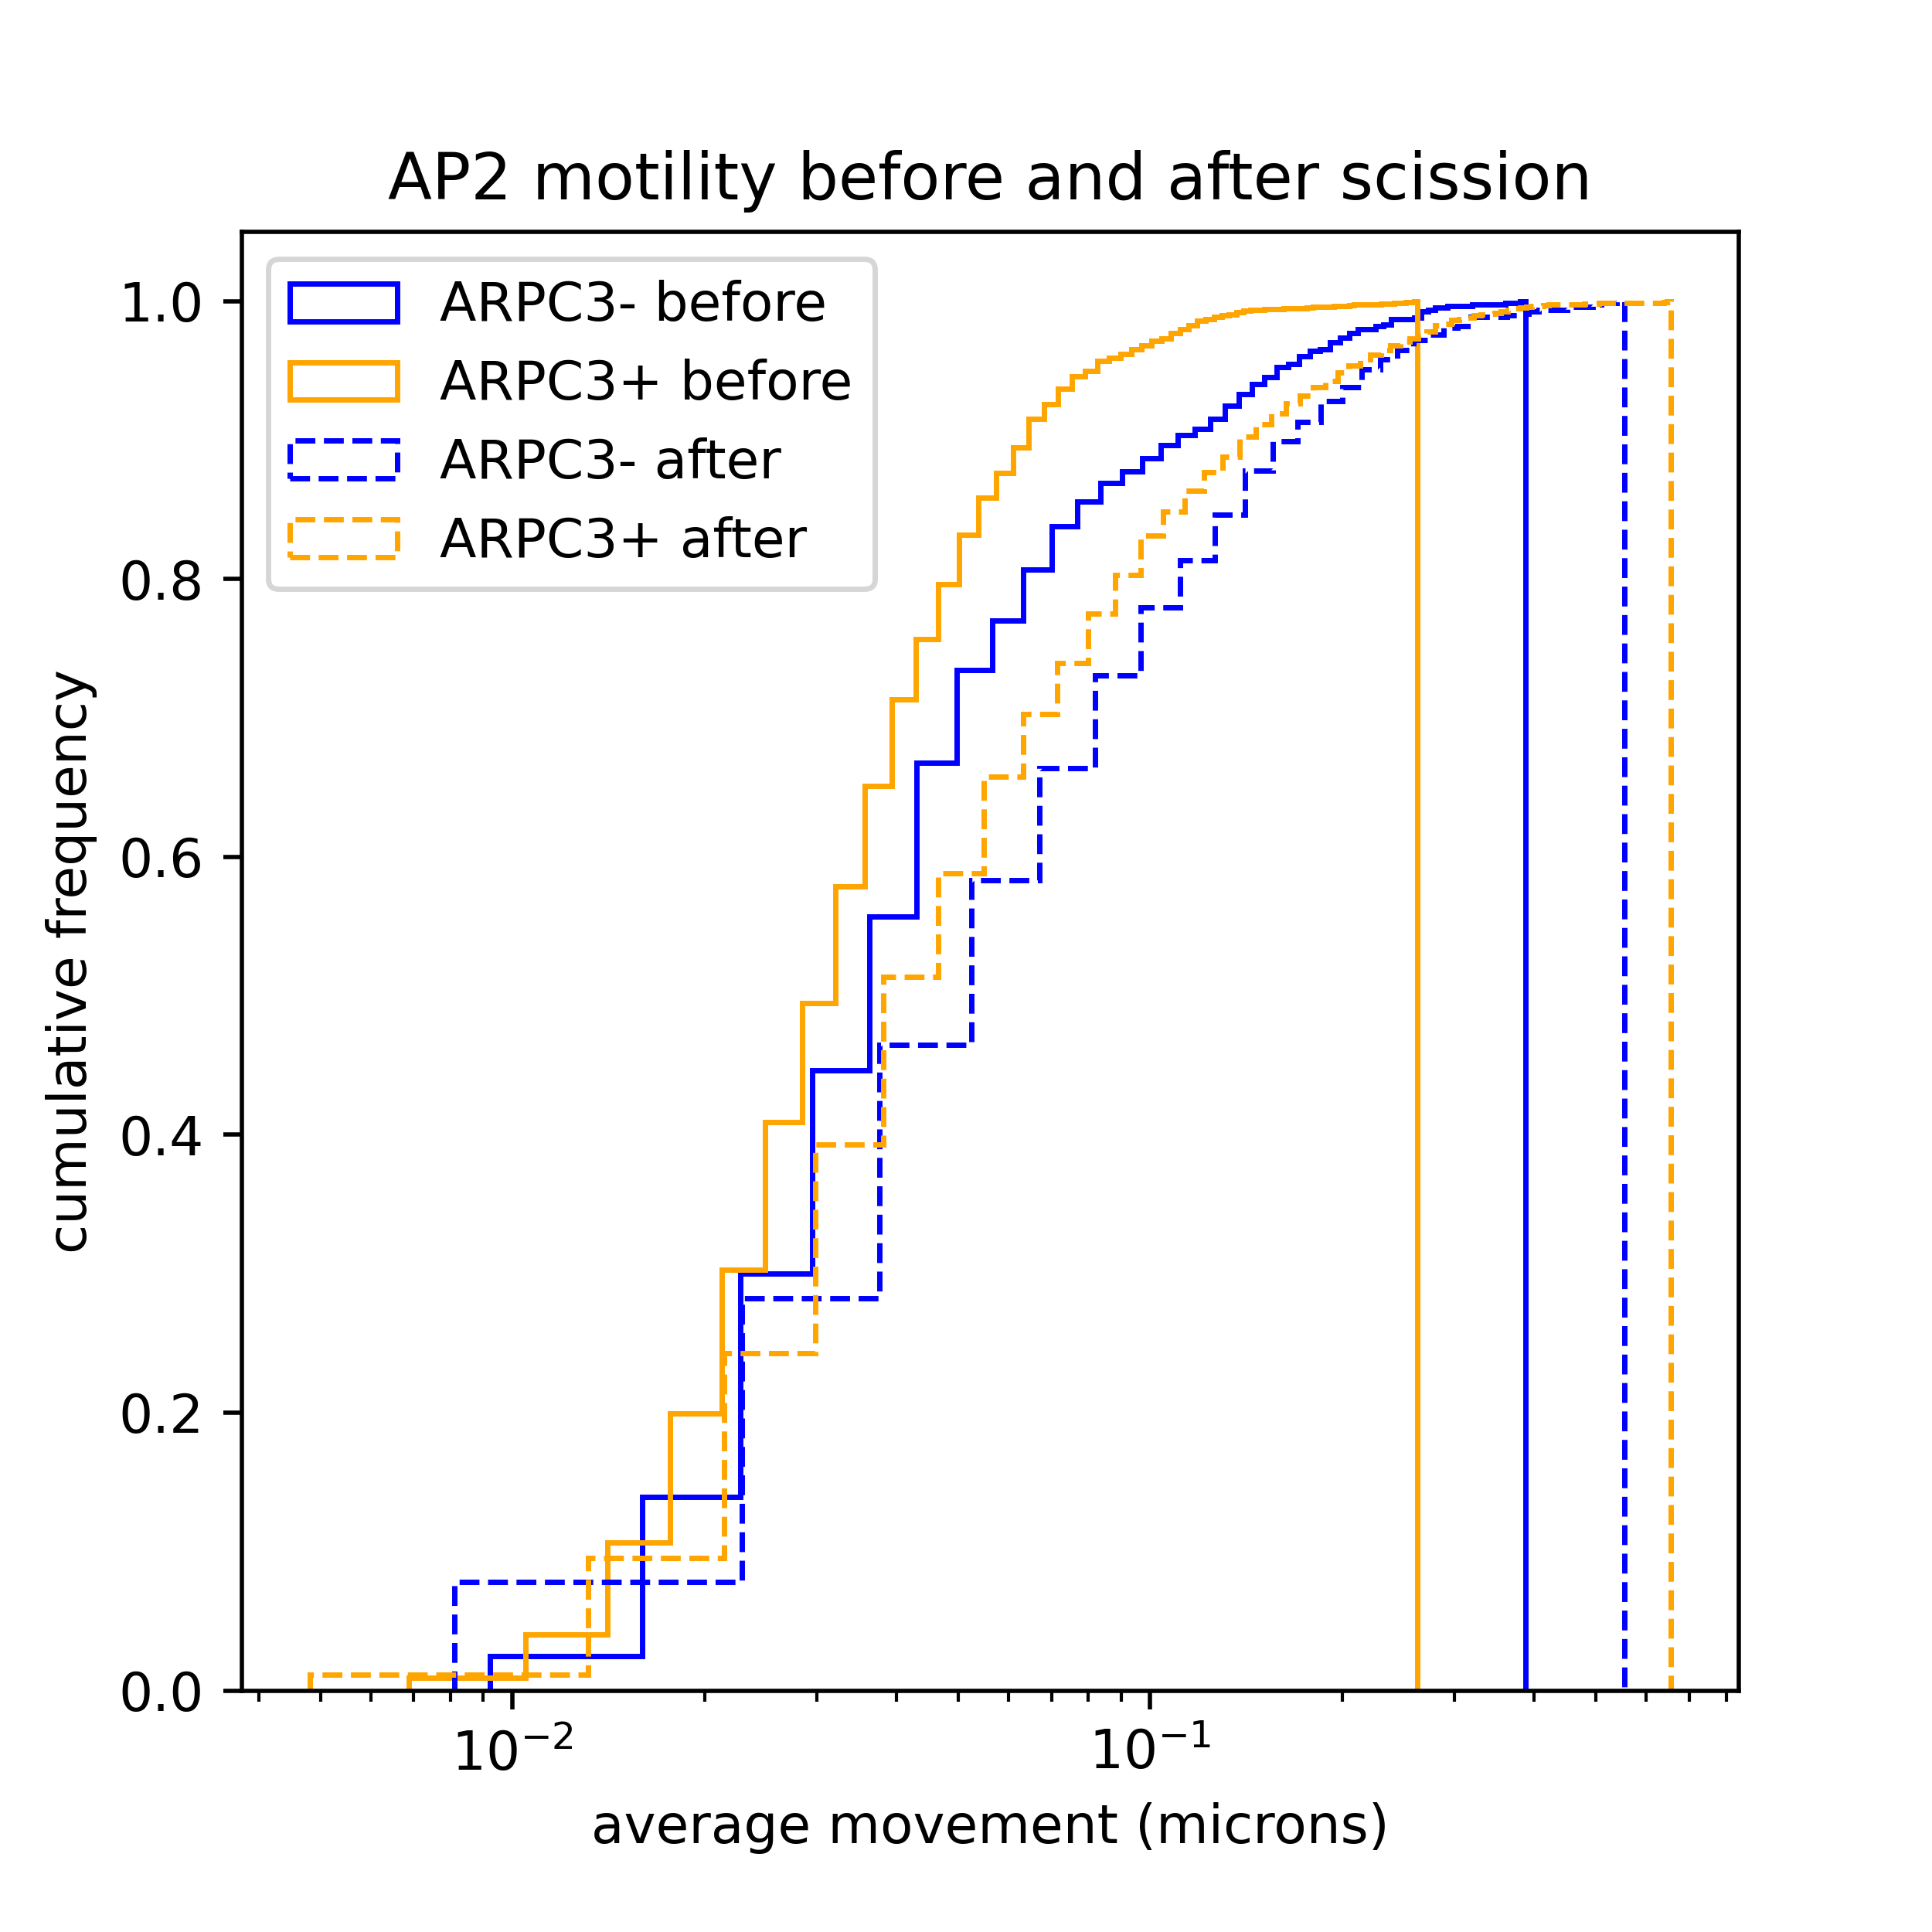

In [25]:
Image(filename=unique_user_saved_outputs+'/plots/ap2movementbeforeafterarpc3plusminus_zeropadding.png', height=500, width=500)

### AP2 motility before and after scission, comparing ARPC3+/-, only ARPC3 events present at scission

In [26]:
%%capture
plt.figure(dpi=500, figsize=(5,5))
plt.xscale('log')
plt.xlabel('average movement (microns)')
plt.ylabel('cumulative frequency')
ax = plt.hist(average_ap2_movement_before_dnm2_peak_arpc3_negative, bins='auto', color='blue', alpha=1, cumulative=True, histtype='step', density=True, label='ARPC3- before')
ax = plt.hist(np.array(average_ap2_movement_before_dnm2_peak_arpc3_positive)[np.where(np.array(significant_arpc3_at_dnm2_peak_arpc3_positive)==1)], bins='auto', color='orange', alpha=1, cumulative=True, histtype='step', density=True, label='ARPC3+ before')
ax = plt.hist(average_ap2_movement_after_dnm2_peak_arpc3_negative, linestyle='--', bins='auto', color='blue', alpha=1, cumulative=True, histtype='step', density=True, label='ARPC3- after')
ax = plt.hist(np.array(average_ap2_movement_after_dnm2_peak_arpc3_positive)[np.where(np.array(significant_arpc3_at_dnm2_peak_arpc3_positive)==1)], linestyle='--', bins='auto', color='orange', alpha=1, cumulative=True, histtype='step', density=True, label='ARPC3+ after')
plt.legend(loc='upper left')
plt.title('AP2 motility before and after scission')
plt.savefig(unique_user_saved_outputs+'/plots/ap2movementbeforeafterarpc3plusminus_onlysigarpc3atscission_zeropadding.png')

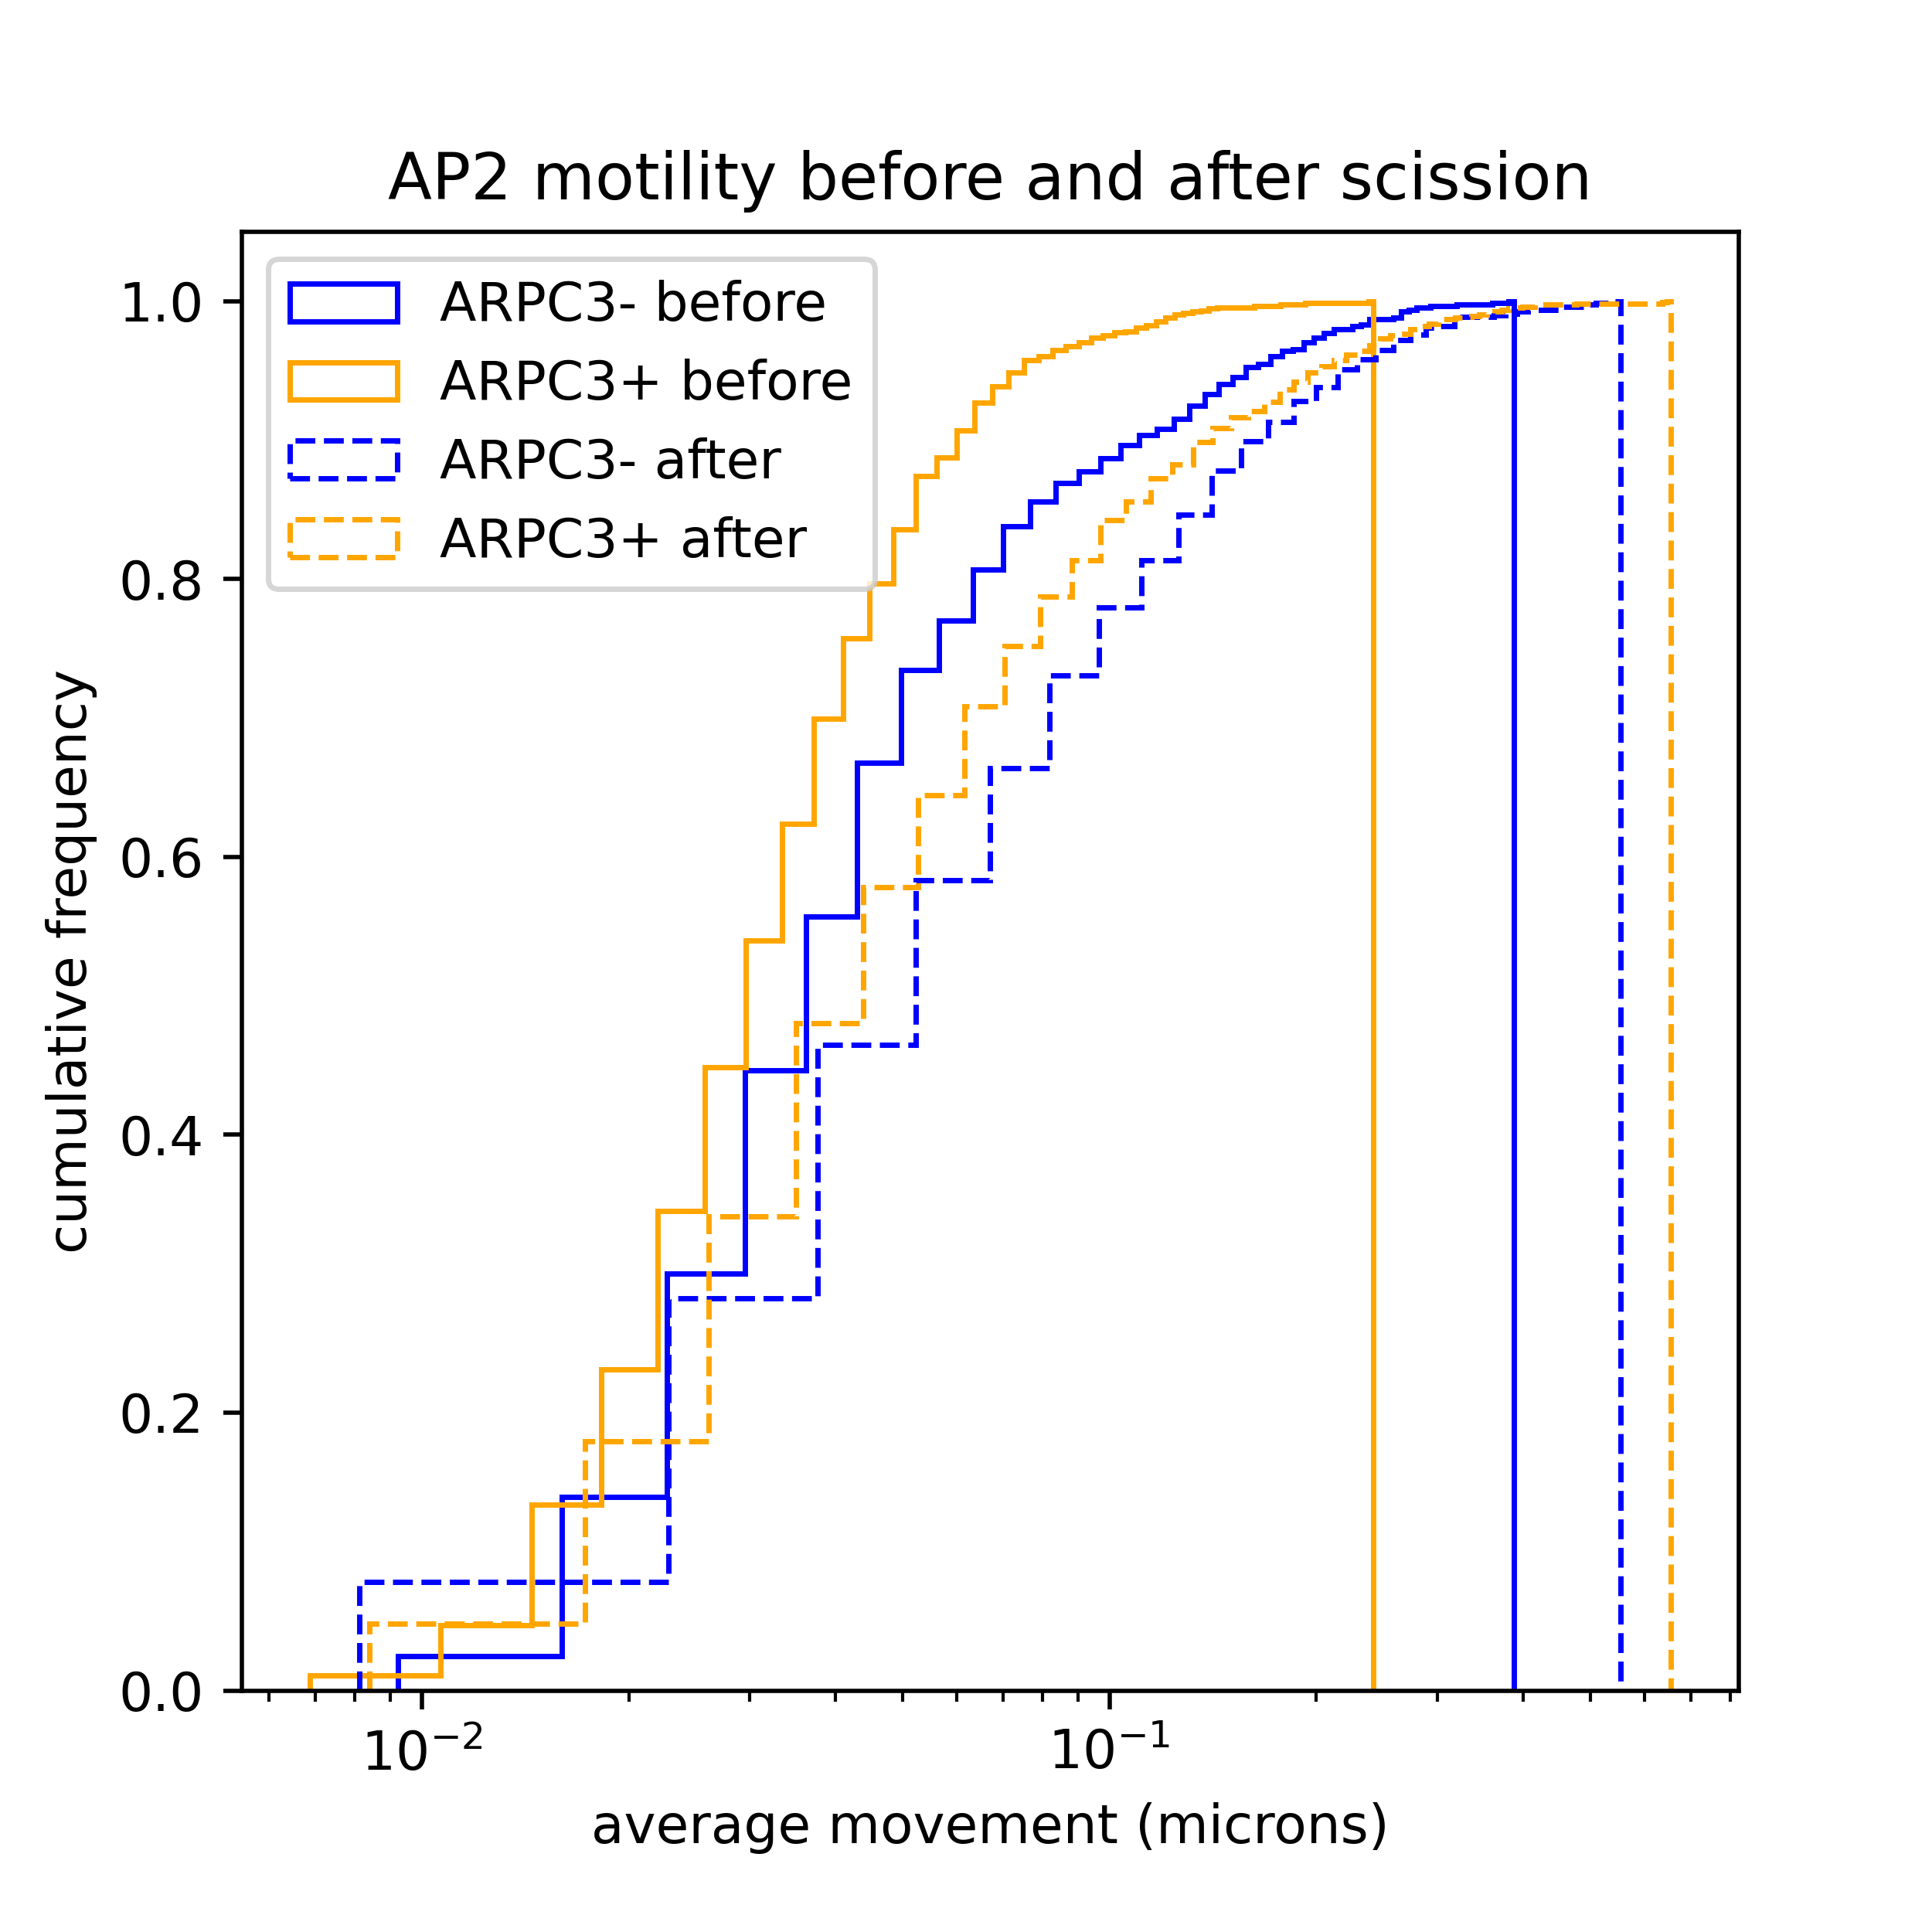

In [27]:
Image(filename=unique_user_saved_outputs+'/plots/ap2movementbeforeafterarpc3plusminus_onlysigarpc3atscission_zeropadding.png', height=500, width=500)

### AP2 motility before and after scission, comparing ARPC3+/-, only ARPC3 events not present at scission

In [28]:
%%capture
plt.figure(dpi=500, figsize=(5,5))
plt.xscale('log')
plt.xlabel('average movement (microns)')
plt.ylabel('cumulative frequency')
ax = plt.hist(average_ap2_movement_before_dnm2_peak_arpc3_negative, bins='auto', color='blue', alpha=1, cumulative=True, histtype='step', density=True, label='ARPC3- before')
ax = plt.hist(np.array(average_ap2_movement_before_dnm2_peak_arpc3_positive)[np.where(np.array(significant_arpc3_at_dnm2_peak_arpc3_positive)==0)], bins='auto', color='orange', alpha=1, cumulative=True, histtype='step', density=True, label='ARPC3+ before')
ax = plt.hist(average_ap2_movement_after_dnm2_peak_arpc3_negative, linestyle='--', bins='auto', color='blue', alpha=1, cumulative=True, histtype='step', density=True, label='ARPC3- after')
ax = plt.hist(np.array(average_ap2_movement_after_dnm2_peak_arpc3_positive)[np.where(np.array(significant_arpc3_at_dnm2_peak_arpc3_positive)==0)], linestyle='--', bins='auto', color='orange', alpha=1, cumulative=True, histtype='step', density=True, label='ARPC3+ after')
plt.legend(loc='upper left')
plt.title('AP2 motility before and after scission')
plt.savefig(unique_user_saved_outputs+'/plots/ap2movementbeforeafterarpc3plusminus_onlynonsigarpc3atscission_zeropadding.png')

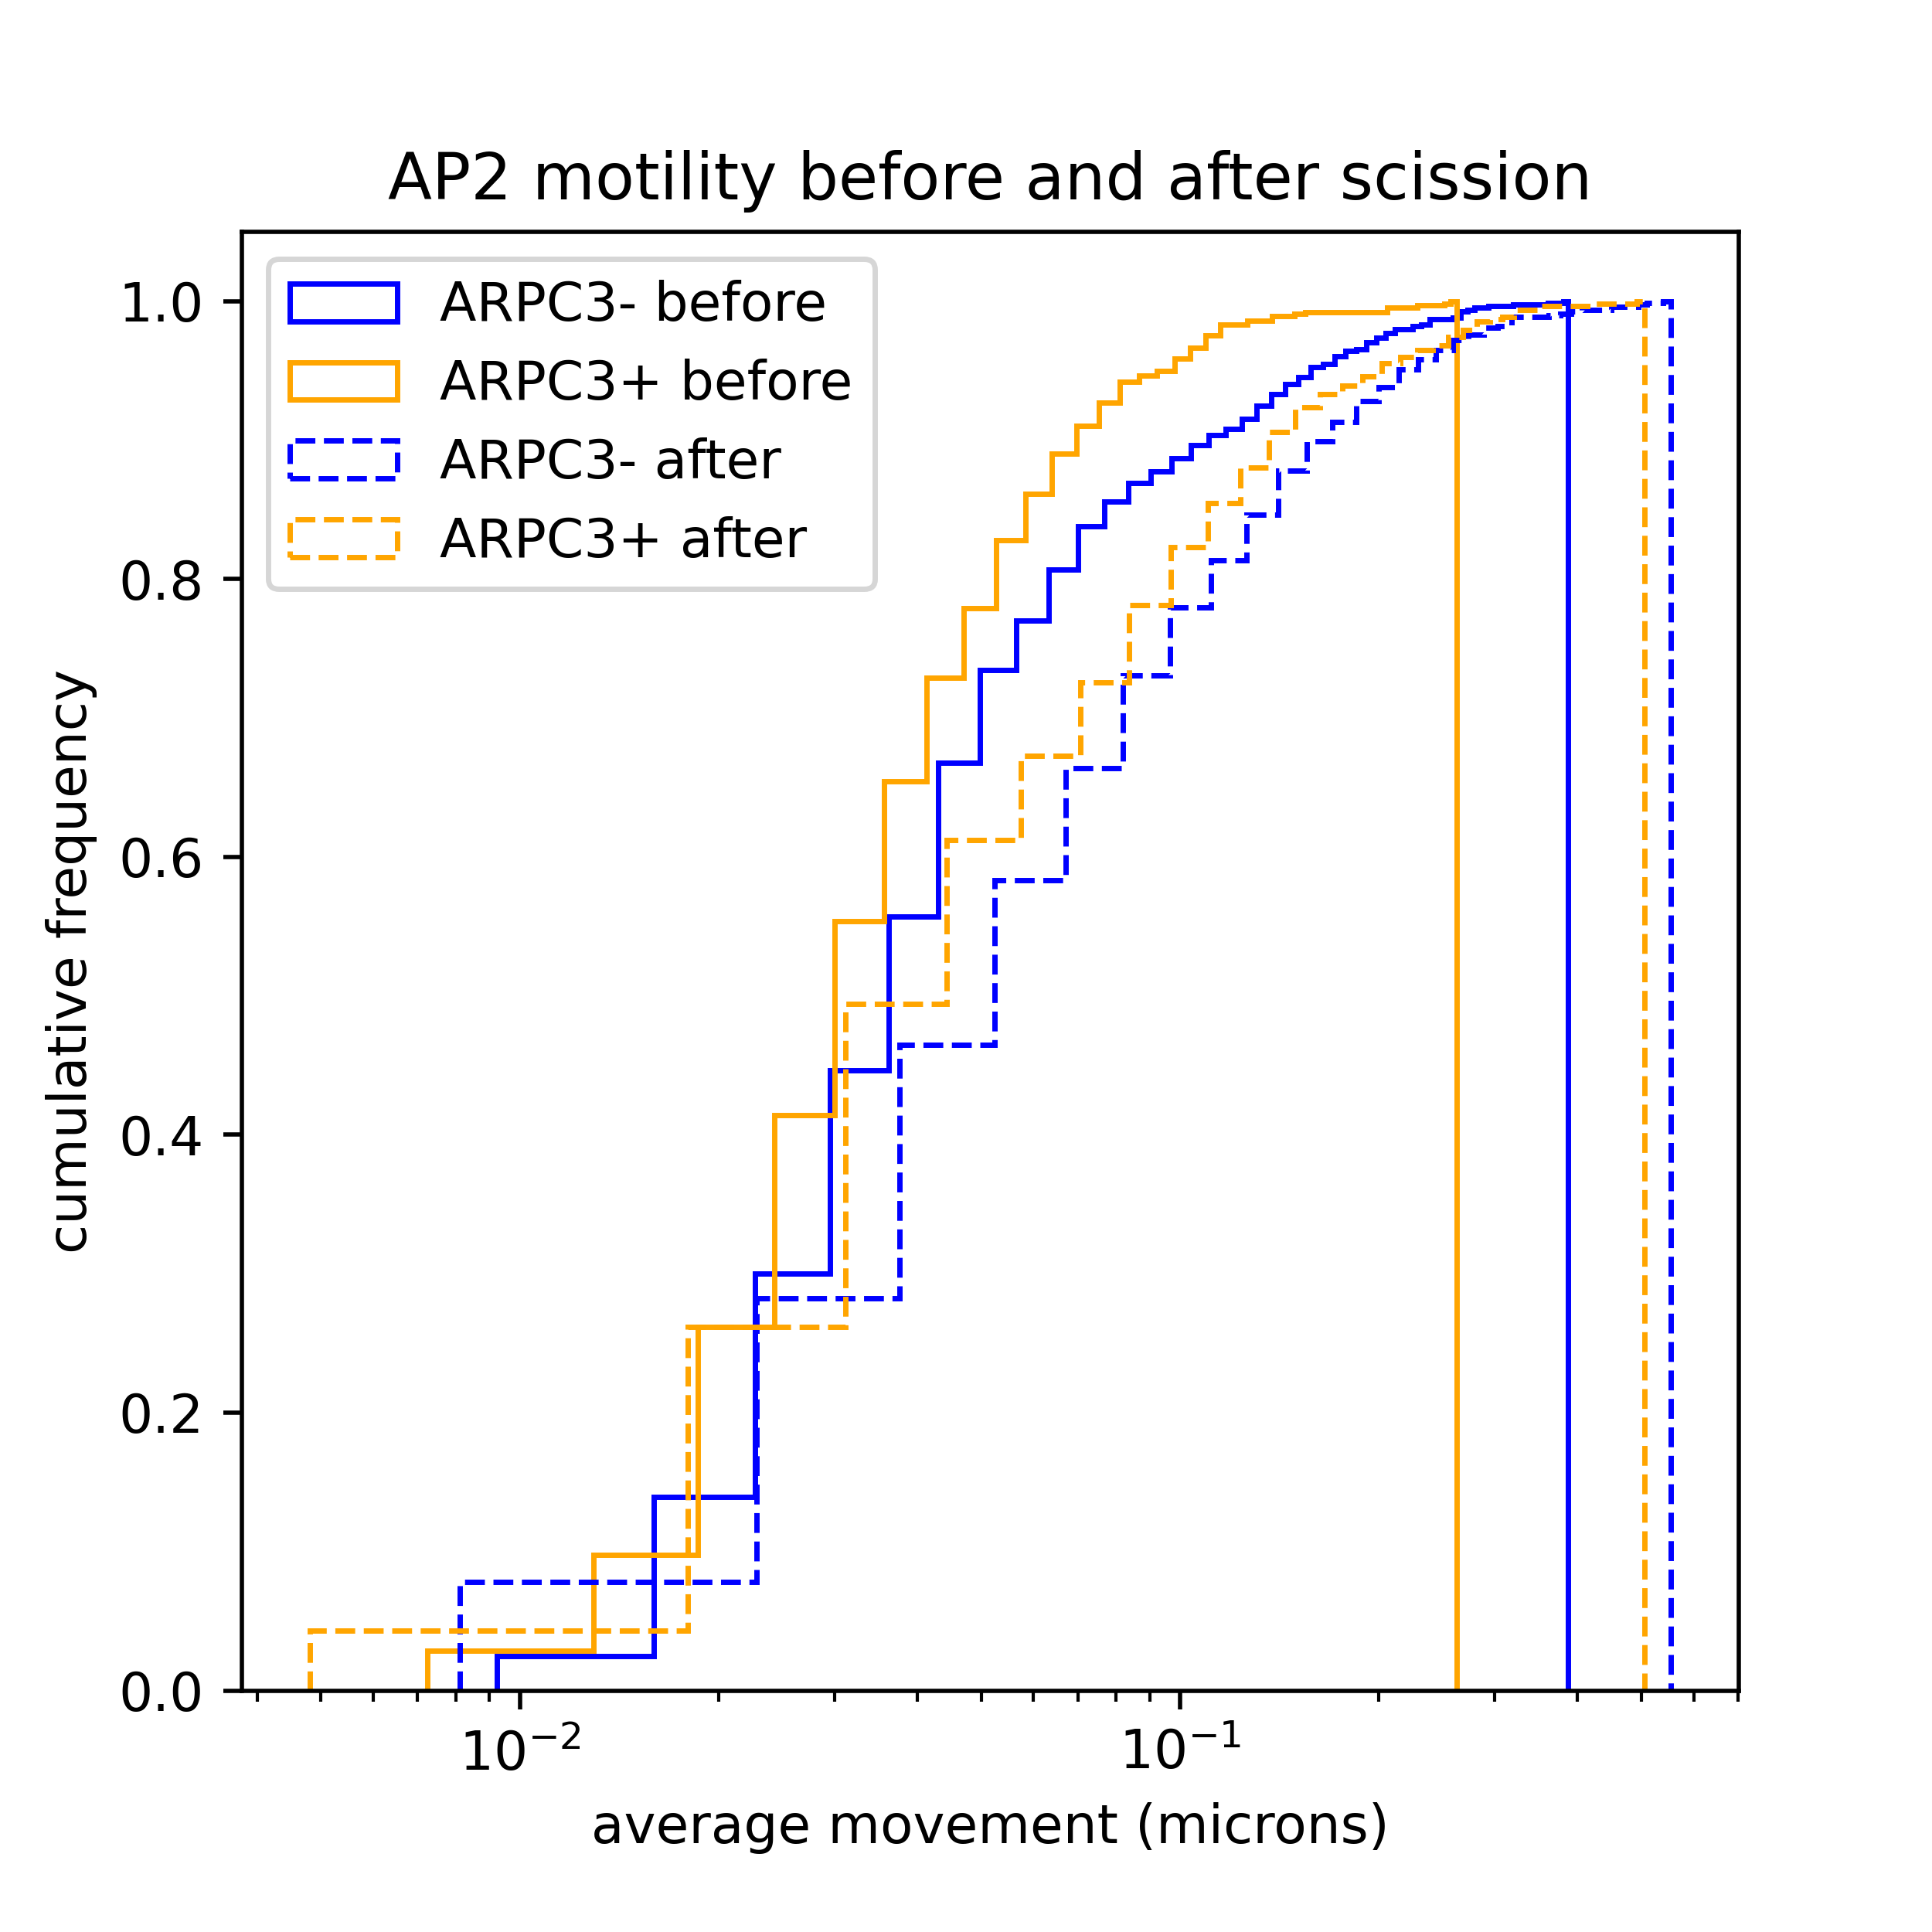

In [29]:
Image(filename=unique_user_saved_outputs+'/plots/ap2movementbeforeafterarpc3plusminus_onlynonsigarpc3atscission_zeropadding.png', height=500, width=500)